In [1]:
from sqlalchemy import create_engine
import pandas as pd
%matplotlib inline

In [2]:
cnxn_string = ("postgresql+psycopg2://{username}:{pswd}"
               "@{host}:{port}/{database}")
print(cnxn_string)

postgresql+psycopg2://{username}:{pswd}@{host}:{port}/{database}


In [3]:
engine = create_engine(cnxn_string.format(
    username="your_username", 
    pswd="your_password", 
    host="your_host.com", 
    port=5432,
    database="sqlda"))

In [4]:
engine.execute("SELECT * FROM customers LIMIT 2;").fetchall()

[(1, None, 'Arlena', 'Riveles', None, 'ariveles0@stumbleupon.com', 'F', '98.36.172.246', None, None, None, None, None, None, None, datetime.datetime(2017, 4, 23, 0, 0)),
 (2, 'Dr', 'Ode', 'Stovin', None, 'ostovin1@npr.org', 'M', '16.97.59.186', '314-534-4361', '2573 Fordem Parkway', 'Saint Louis', 'MO', '63116', 38.5814, -90.2625, datetime.datetime(2014, 10, 2, 0, 0))]

In [5]:
customers_data = pd.read_sql_table('customers', engine)

In [6]:
query = """
    SELECT city,
           COUNT(1) AS number_of_customers,
           COUNT(NULLIF(gender, 'M')) AS female,
           COUNT(NULLIF(gender, 'F')) AS male
    FROM customers
    WHERE city IS NOT NULL
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 20
"""
top_cities_data = pd.read_sql_query(query, engine)

In [7]:
top_cities_data

,city,number_of_customers,female,male
0,Washington,1447,734,713
1,Houston,904,446,458
2,New York City,731,369,362
3,El Paso,713,369,344
4,Dallas,607,309,298
5,Atlanta,571,292,279
6,Sacramento,506,244,262
7,Los Angeles,466,241,225
8,San Antonio,426,207,219
9,Miami,426,195,231


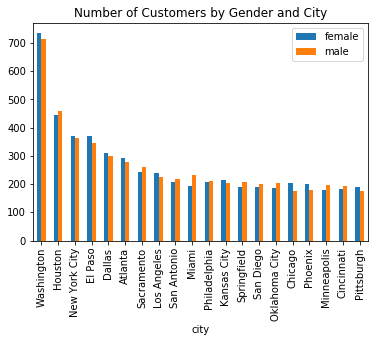

In [8]:
ax = top_cities_data.plot.bar('city', y=['female', 'male'], title='Number of Customers by Gender and City')

## Writing data to the database using Python

In [9]:
top_cities_data.to_sql('top_cities_data', engine, 
                       index=False, if_exists='replace')

## Improving Python Write Speed with COPY

In [10]:
import csv
from io import StringIO

from sqlalchemy import create_engine

def psql_insert_copy(table, conn, keys, data_iter):
    # gets a DBAPI connection that can provide a cursor
    dbapi_conn = conn.connection
    with dbapi_conn.cursor() as cur:
        s_buf = StringIO()
        writer = csv.writer(s_buf)
        writer.writerows(data_iter)
        s_buf.seek(0)

        columns = ', '.join('"{}"'.format(k) for k in keys)
        if table.schema:
            table_name = '{}.{}'.format(table.schema, table.name)
        else:
            table_name = table.name

        sql = 'COPY {} ({}) FROM STDIN WITH CSV'.format(
            table_name, columns)
        cur.copy_expert(sql=sql, file=s_buf)

In [11]:
top_cities_data.to_sql('top_cities_data', engine, 
                       index=False, if_exists='replace',
                       method=psql_insert_copy)

## Reading and Writing csv files with Python

In [12]:
top_cities_data.to_csv('top_cities_analysis.csv', index=False)
my_data = pd.read_csv('top_cities_analysis.csv')
my_data

,city,number_of_customers,female,male
0,Washington,1447,734,713
1,Houston,904,446,458
2,New York City,731,369,362
3,El Paso,713,369,344
4,Dallas,607,309,298
5,Atlanta,571,292,279
6,Sacramento,506,244,262
7,Los Angeles,466,241,225
8,San Antonio,426,207,219
9,Miami,426,195,231
